10_reps_isolation_OFF_160915-144802_results.json
10_reps_isolation_ON_160915-144533_results.json
11_reps_isolation_OFF_160915-145351_results.json
11_reps_isolation_ON_160915-145103_results.json
12_reps_isolation_OFF_160915-150003_results.json
12_reps_isolation_ON_160915-145704_results.json
1_reps_isolation_OFF_160915-141424_results.json
SKIPPING: 1_reps_isolation_OFF_CORE_BUDGET_160915-151100_results.json
1_reps_isolation_ON_160915-141325_results.json
2_reps_isolation_OFF_160915-141635_results.json
SKIPPING: 2_reps_isolation_OFF_CORE_BUDGET_160915-151200_results.json
2_reps_isolation_ON_160915-141526_results.json
3_reps_isolation_OFF_160915-141915_results.json
SKIPPING: 3_reps_isolation_OFF_CORE_BUDGET_160915-151309_results.json
3_reps_isolation_ON_160915-141755_results.json
4_reps_isolation_OFF_160915-142215_results.json
SKIPPING: 4_reps_isolation_OFF_CORE_BUDGET_160915-151430_results.json
4_reps_isolation_ON_160915-142043_results.json
5_reps_isolation_OFF_160915-142535_results.json
S

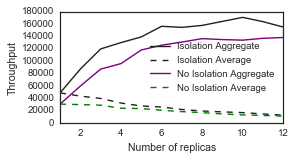

In [22]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
from matplotlib.patches import Rectangle
import seaborn as sns
%matplotlib inline


sns.set_style("white")
sns.set_context("paper", font_scale=1.2,)

fig_dir = "/Users/crankshaw/model-serving/clipper_paper/ModelServingPaper/nsdi_2017/figs2"

# results_dir = os.path.abspath("/Users/crankshaw/clipper/experiments_logs/spark_svm_resource_isolation/")
results_dir = os.path.abspath("/Users/crankshaw/clipper/experiments_logs/sklearn_svm_resource_isolation/")



results_files = []

for name in os.listdir(results_dir):
    if "results" in name:
        if not "CORE_BUDGET" in name:
            print name
            results_files.append(name)
        else:
            print "SKIPPING: %s" % name
print results_files
def is_replica_thru(n):
    return "model_thruput" in n and ("172" in n or "169" in n)

def get_all_thruputs(res):
    agg_thru = [m["rate"] for m in res["meters"] if "linear_svm:model_thruput" in m["name"]][0]
#     agg_thru = [m["rate"] for m in res["meters"] if "spark_svm:model_thruput" in m["name"]][0]

    rep_thrus = [m["rate"] for m in res["meters"] if is_replica_thru(m["name"])]
    return (agg_thru, np.array(rep_thrus))

def extract_results(i, df_iso_on, df_iso_off, fname):
    with open(os.path.join(results_dir, fname), "r") as f:
        splits = fname.split("_")
#         print splits
        # 10_reps_isolation_OFF_160915-050009_config.json
        num_reps = int(splits[0])
        if splits[3] == "OFF":
            iso_on = False
        else:
            assert splits[3] == "ON"
            iso_on = True
        res = json.load(f)
        agg_thru, rep_thrus = get_all_thruputs(res)
        avg_thru = np.mean(rep_thrus)
        if iso_on:
            df_iso_on.loc[i] = [num_reps, agg_thru, avg_thru]
        else:
            df_iso_off.loc[i] = [num_reps, agg_thru, avg_thru]

    return rep_thrus

df_iso_on = pd.DataFrame(columns=("total_reps", "aggregate_thru", "avg_thru"))
df_iso_off = pd.DataFrame(columns=("total_reps", "aggregate_thru", "avg_thru"))

all_rep_thrus = [extract_results(i, df_iso_on, df_iso_off, r) for (i,r) in enumerate(results_files)]


def plot_thruputs(df, ax, cagg, cavg, label):
    colors = sns.cubehelix_palette(2, start=2.8, rot=-0.1)
    df.sort_values("total_reps", inplace=True)
    
    df.plot(x="total_reps", y="aggregate_thru", ax=ax, color=cagg, label="%s Aggregate" % label)
    df.plot(x="total_reps", y="avg_thru", ax=ax, ls="--", color=cavg, label="%s Average" % label)

agg_colors = sns.dark_palette("purple", 2)
avg_colors = sns.dark_palette("green", 2)

fig, ax = plt.subplots(figsize=(4,2))
plot_thruputs(df_iso_on, ax, agg_colors[0], avg_colors[0], "Isolation")
plot_thruputs(df_iso_off, ax, agg_colors[1], avg_colors[1], "No Isolation")
ax.set_ylabel("Throughput")
ax.set_xlabel("Number of replicas")
# ax.set_title("Local Replicas: %d" % df["local_reps"].max())
ax.legend(loc=0)
